# SENTIMENT AND URGENCY TEXT ANALYSIS

## 1. Introduction

### Objective
While the app's main functionality centers on capturing and analyzing images of utility poles for maintenance and safety concerns, the integrated text box feature serves a crucial supplementary role, it allows customers to provide additional context, report specific issues, and express their concerns or feedback regarding the utility services.

To maximize the utility of this textual input, we plan to implement these analytical strategies:
- Using VADER for Sentiment Polarity - This will enable us to understand the customer's emotional tone, whether they are expressing positive, neutral, or negative emotions regarding the utility services or reported issues.
- Implementing an Urgency Score System - This system will prioritize issues that require immediate attention, such as outages, emergencies, or safety hazards.


### Dataset Description

This project utilizes the HumAID Twitter dataset, which consists of manually annotated tweets collected during eleven significant natural disaster events from 2016 to 2019. 
We use this HumAID Twitter dataset as a stand-in for actual customer data from SDG&E due to the current lack of available customer interactions. Our approach utilizes these annotated tweets as a proxy to develop and refine our sentiment analysis and topic classification models.

Link: https://crisisnlp.qcri.org/humaid_dataset

The dataset is organized into separate folders for each of the following natural disaster events:

- Canada Wildfires (2016)
- Cyclone Idai (2019)
- Ecuador Earthquake (2016)
- Hurricane Harvey (2017)
- Hurricane Irma (2017)
- Hurricane Maria (2017)
- Hurricane Matthew (2016)
- Italy Earthquake (August 2016)
- Kaikoura Earthquake (2016)
- Puebla Mexico Earthquake (2017)
- Sri Lanka Floods (2017)

For each event, the dataset is divided into three subsets: Training Set, Validation Set and Test Set.

Each subset consists of tab-separated values (TSV) files containing 3 columns: tweet_id, tweet_text, class_label.

## 2. Setup

### Library import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tramnguyen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Data import

In [2]:
events = [
    "canada_wildfires_2016", "cyclone_idai_2019", "ecuador_earthquake_2016",
    "hurricane_harvey_2017", "hurricane_irma_2017", "hurricane_maria_2017",
    "hurricane_matthew_2016", "italy_earthquake_aug_2016", "kaikoura_earthquake_2016",
    "puebla_mexico_earthquake_2017", "srilanka_floods_2017"
]

dataframes = {event: {} for event in events}

# Loop through each event and load train, dev, and test sets
for event in events:
    for set_type in ['train', 'dev', 'test']:
        file_path = f'../data/HumAID/{event}/{event}_{set_type}.tsv'
        # Load the dataset and store it in the dictionary under the appropriate event and set type
        dataframes[event][set_type] = pd.read_csv(file_path, sep='\t')

We can access each DataFrame using its event name as the key in the 'dataframes' dictionary.

For example: Access the training set for 'canada_wildfires_2016' dataframe:

In [3]:
canada_wildfires_train_df = dataframes['canada_wildfires_2016']['train']
canada_wildfires_train_df.head()

,tweet_id,tweet_text,class_label
0,735891446960623616,RT @DonBradshawNTV: How @MarshallAmpsUK came t...,other_relevant_information
1,731202020296818688,Red Cross distributes $30M to Fort McMurray wi...,displaced_people_and_evacuations
2,733665357236342784,Interesting insights on the shifting communica...,other_relevant_information
3,731963038429929472,RT @globeandmail: Oil sands producers helping ...,rescue_volunteering_or_donation_effort
4,728674838034944001,Ottawa to match Red Cross donations for Fort M...,rescue_volunteering_or_donation_effort


Combine all events into a 3 pandas dataframes for training, validation and testing:

In [4]:
train_dfs = []
dev_dfs = []
test_dfs = []

# Iterate over each event and set type, adding the event name as a column
for event, sets in dataframes.items():
    for set_type, df in sets.items():
        df['event'] = event  # Add the event name as a column
        
        # Append the DataFrame to the appropriate list based on the set type
        if set_type == 'train':
            train_dfs.append(df)
        elif set_type == 'dev':
            dev_dfs.append(df)
        elif set_type == 'test':
            test_dfs.append(df)

# Concatenate the lists of DataFrames into three large DataFrames
train_df = pd.concat(train_dfs, ignore_index=True)
val_df = pd.concat(dev_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

### Data Overview

In [5]:
train_df.head()

,tweet_id,tweet_text,class_label,event
0,735891446960623616,RT @DonBradshawNTV: How @MarshallAmpsUK came t...,other_relevant_information,canada_wildfires_2016
1,731202020296818688,Red Cross distributes $30M to Fort McMurray wi...,displaced_people_and_evacuations,canada_wildfires_2016
2,733665357236342784,Interesting insights on the shifting communica...,other_relevant_information,canada_wildfires_2016
3,731963038429929472,RT @globeandmail: Oil sands producers helping ...,rescue_volunteering_or_donation_effort,canada_wildfires_2016
4,728674838034944001,Ottawa to match Red Cross donations for Fort M...,rescue_volunteering_or_donation_effort,canada_wildfires_2016


In [6]:
train_df.count()

tweet_id       28802
tweet_text     28802
class_label    28802
event          28802
dtype: int64

In [7]:
val_df.count()

tweet_id       4193
tweet_text     4193
class_label    4193
event          4193
dtype: int64

In [8]:
val_df.count()

tweet_id       4193
tweet_text     4193
class_label    4193
event          4193
dtype: int64

In [9]:
test_df.count()

tweet_id       8157
tweet_text     8157
class_label    8157
event          8157
dtype: int64

There are 28802 rows in training set. 4193 rows in validation set and 8157 rows in testing set.

The following are the labels and the frequency of each label in the training set:

In [10]:
train_df['class_label'].value_counts()

class_label
rescue_volunteering_or_donation_effort    8212
other_relevant_information                5143
infrastructure_and_utility_damage         4151
sympathy_and_support                      3253
injured_or_dead_people                    2578
caution_and_advice                        1533
displaced_people_and_evacuations          1496
not_humanitarian                          1284
requests_or_urgent_needs                  1139
missing_or_found_people                     13
Name: count, dtype: int64

In [11]:
# Check for null values
null_values = train_df['tweet_text'].isnull().sum()
print(f"Number of null values in 'tweet_text': {null_values}")

# Check for empty strings
empty_strings = (train_df['tweet_text'] == '').sum()
print(f"Number of empty strings in 'tweet_text': {empty_strings}")

Number of null values in 'tweet_text': 0
Number of empty strings in 'tweet_text': 0


For data pre-processing, we won't remove punctuation or capitalization of the text data because  it's best to keep the text as close to its original form as possible to preserves the nuances that VADER can interpret for sentiment analysis. 

## 3. Apply VADER for Sentiment Polarity

In [12]:
# Initialize Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

def sentiment_score(text):
    return sia.polarity_scores(text)

# Compound score is computed by standardizing neutral, negative and positive score
def compound_score(text):
    return sia.polarity_scores(text)['compound']

# Result of the sentiment scores
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

Now we can get sentiment score on each text input:

In [13]:
train_df['sentiment_score'] = train_df['tweet_text'].apply(sentiment_score)
train_df['compound_score'] = train_df['tweet_text'].apply(compound_score)

In [14]:
train_df['sentiment'] = train_df['compound_score'].apply(classify_sentiment)

In [15]:
train_df[['tweet_text', 'sentiment_score', 'compound_score', 'sentiment']].head()

,tweet_text,sentiment_score,compound_score,sentiment
0,RT @DonBradshawNTV: How @MarshallAmpsUK came t...,"{'neg': 0.11, 'neu': 0.89, 'pos': 0.0, 'compou...",-0.2732,negative
1,Red Cross distributes $30M to Fort McMurray wi...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
2,Interesting insights on the shifting communica...,"{'neg': 0.0, 'neu': 0.838, 'pos': 0.162, 'comp...",0.4019,positive
3,RT @globeandmail: Oil sands producers helping ...,"{'neg': 0.101, 'neu': 0.759, 'pos': 0.139, 'co...",0.1531,positive
4,Ottawa to match Red Cross donations for Fort M...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral


#### Visualization of the Compound Sentiment Scores

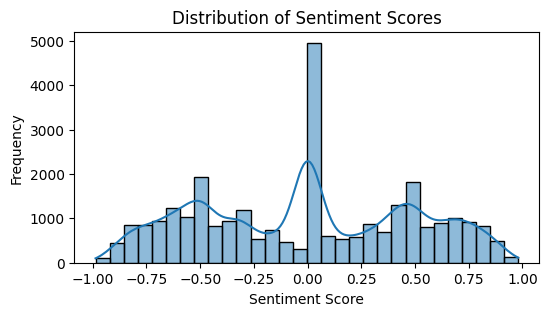

In [16]:
plt.figure(figsize=(6, 3))
sns.histplot(train_df['compound_score'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

- The distribution appears to be bimodal, with two prominent peaks, suggesting two common sentiment intensities among the tweets.

- There is a significant spike around the 0 mark which indicates a large number of tweets have a neutral sentiment score.

## 4. Implement an Urgency Score System
